In [68]:
import pandas as pd
import itertools
import numpy as np
import random
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from IPython.display import display, HTML
from sklearn.preprocessing import StandardScaler
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 70)

# Overview

### Objective
* Form a team of players whose total yearly salary for the 2021-22 season fits within a range using advanced statistics as the independent variables and the number of wins produced by that team as the dependent variable in a regression task

### Dataset Source
* https://www.basketball-reference.com
* Downloaded the csv files for each required feature and did some preprocessing

# Dataset

### Relevant dataframes
* adv_stats: contains advanced statistics for each player
* standard_stats: contains standard statistics for each player
* salaries: contains the 2021-22 salaries for each player
* combined_data: adv_stats + salaries


In [86]:
adv_stats = pd.read_excel("./data/nba_moneyball/adv_stats.csv").drop("Rk", axis=1)
full_salaries = pd.read_excel("./data/nba_moneyball/salaries.csv").drop("Rk", axis=1).rename(columns = {"2021-22":"2021-22 Salary"})
standings = pd.read_excel("./data/nba_moneyball/standings.csv")

salaries = full_salaries[["Player", "2021-22 Salary"]]

combined_data = pd.merge(adv_stats, full_salaries[["Player", "2021-22 Salary"]], on=["Player"]).drop_duplicates()
print("Player Information")
print(list(combined_data.columns))

Player Information
['Player', 'Pos', 'Age', 'Tm', 'G', 'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', '2021-22 Salary']


In [3]:
# display(combined_data)
# display(combined_data[combined_data["Tm"] == "TOT"])

# Parameters

* min_games_played: minimum number of games played for a player
* min_min_played: minimum number of average minutes for a player
* desired_yearly_sal_min: minimum total yearly salary for a team 
* desired_yearly_sal_max: maximum total yearly salary for a team 

* combos_considered: how many different combinations of players considered during the testing stage
* num_players: number of players in a team
* position_matters: whether we care about the positions of players
* teams_considered : how many teams are considered in the combinations generated

In [4]:
min_games_played = 41
min_min_played = 25
desired_yearly_sal_min = 50000000
desired_yearly_sal_max = 70000000

combos_considered = 30000
num_players = 5
position_matters = True
teams_considered = 30000

# Data Parsing

This is an area that could be modified based on basketball knowledge and research

Assumptions made:
* Players that played on multiple teams in a season do not adequately contribute to the wins of the respective teams
* Players that play a desired number of games and minutes contribute to a team's wins

In [5]:
parsed_data = combined_data[combined_data["Tm"] != "TOT"]
# parsed_data = parsed_data[parsed_data["G_x"] >= min_games_played]
# parsed_data = parsed_data[parsed_data["MP_x"] >= min_min_played].reset_index(drop=True)
# parsed_data = parsed_data.drop("Pos_x", axis=1).drop("Age_x", axis=1).drop("G_x", axis=1).drop("MP_x", axis=1)
# parsed_data = parsed_data.drop("Pos_y", axis=1).drop("Age_y", axis=1).drop("Tm_y", axis=1).drop("G_y", axis=1).drop("GS", axis=1).drop("MP_y", axis=1)

parsed_data = parsed_data[parsed_data["G"] >= min_games_played]
parsed_data = parsed_data[parsed_data["MP"] >= min_min_played].reset_index(drop=True)
parsed_data = parsed_data.drop("G", axis=1).drop("MP", axis=1)
# parsed_data = parsed_data.sort_values(by=['Pos']).reset_index(drop=True)

players_considered = len(parsed_data)

if position_matters:  
    temp = parsed_data.groupby('Pos')
    data_by_positions = [x for _, x in temp]

In [ ]:
# display(standings)

# Generating Training Data

1. Training data is generated based on the 2021-22 season standings
2. Given a list of players and their statistics and salaries, iterate through each player and determine the team, number of minutes played, and number of games played by that player
3. Group players according to team, and keep players that fit the criteria of games played and minutes played
4. Generate all combinations of teams (based on the num_players parameter), average out their advanced statistics to get independent variables and assigned their number of wins as the number of wins from their respective team in the 2021-22 season standings

In [7]:
teams = standings["Team"]
team_wins = standings["Wins"]

players_dict = {}
for i in range(len(parsed_data)):
    team = parsed_data.iloc[i]["Tm"]
    if team not in players_dict:
        players_dict[team] = [i]
    else:
        players_dict[team].append(i)

In [8]:
temp_data = parsed_data
parsed_data = parsed_data.drop("Tm", axis=1)
parsed_data = parsed_data.drop("Pos", axis=1)

In [9]:
different_teams = []

teams_dict = {"MIA": "Miami Heat", "NOP": "New Orleans Pelicans", "MEM": "Memphis Grizzlies", "MIL": "Milwaukee Bucks", "POR": "Portland Trail Blazers", "WAS": "Washington Wizards", "PHO": "Phoenix Suns", "CHO": "Charlotte Hornets", "SAC": "Sacramento Kings", "NYK": "New York Knicks", "DEN": "Denver Nuggets", "LAC": "Los Angeles Clippers", "GSW": "Golden State Warriors", "OKC": "Oklahoma City Thunder", "TOR": "Toronto Raptors", "DET": "Detroit Pistons", "UTA": "Utah Jazz", "IND": "Indiana Pacers", "DAL": "Dallas Mavericks", "BRK": "Brooklyn Nets", "BOS": "Boston Celtics", "HOU": "Houston Rockets", "LAL": "Los Angeles Lakers", "ATL": "Atlanta Hawks", "PHI": "Philadelphia 76ers", "SAS": "San Antonio Spurs", "MIN": "Minnesota Timberwolves", "CLE": "Cleveland Cavaliers", "CHI": "Chicago Bulls", "ORL": "Orlando Magic"}

for key, value in players_dict.items():
    wins = standings[standings["Team"] == teams_dict[key]]["Wins"].values[0]
    
    different_teams.append((wins, list(itertools.combinations(value, num_players))))

X = []
y = [] 
for i in range(len(different_teams)):
    team = different_teams[i][1]
    for j in range(len(team)):
        players = list(team[j])
        averages = parsed_data.iloc[players].mean(axis=0).tolist()[:-1]
        X.append(averages)
        y.append(different_teams[i][0])

30


In [89]:
print("Example Train Instance X")
print(X[0])
print("\n")
print("Example Train Instance y")
print(y[0])

Example Train Instance X
[26.0, 17.94, 0.5756, 0.2036, 0.3754, 5.9, 17.82, 11.96, 22.4, 1.6800000000000002, 2.0, 13.440000000000001, 23.560000000000002, 2.5599999999999996, 1.94, 4.48, 0.12680000000000002, 0.66, 0.3, 0.9800000000000001, 1.56]


Example Train Instance y
18064315.0


# Generating Testing Data

The testing data is more like hold out data. It is not from the same distribution as the training data since we want to know teams that haven't been formed before and for which we don't have historical data regarding wins.

1. Generate a set of n person teams 
    * Since there are a lot of possible combinations of say 5 person teams, we select 5 random numbers instead from the list of possible player indices
    * We won't be able to generate all possible teams, and if we only generated a subset of all combinations, then we are likely to only consider a small number of players
    * Using random numbers helps us with this
2. Average the teams statistics and filter the yearly salaries to fit within the desired range

In [10]:
# indices = [i for i in range(len(parsed_data))]
# all_combos = list(itertools.combinations(indices[:players_considered], num_players))
# print(len(all_combos))


data_len = len(parsed_data)

# start_index 

def get_five():
    random_set = []
    if position_matters:
        for i in range(len(data_by_positions)):
            random_index = random.randint(0, len(data_by_positions[i]) - 1)

            while random_index in random_set:
                random_index = random.randint(0, len(data_by_positions[i]) - 1)
            new_index = data_by_positions[i].iloc[random_index].name
            random_set.append(new_index)
    else:
        for i in range(num_players):
            random_index = random.randint(0, data_len - 1)
            while random_index in random_set:
                random_index = random.randint(0, data_len - 1)
            random_set.append(random_index)
    return random_set

all_combos = [get_five() for i in range(teams_considered)]

In [11]:
salaries = parsed_data["2021-22 Salary"].tolist()
players = parsed_data["Player"]

team_salaries = []

for i in range(len(all_combos[:combos_considered])):
    total_sal = 0
    for j in range(num_players):
        total_sal += salaries[all_combos[i][j]]
        
    if total_sal <= desired_yearly_sal_max and total_sal >= desired_yearly_sal_min:  
        team_salaries.append((total_sal, all_combos[i]))

extra_test_X = []
extra_teams_X = []
for sal in team_salaries:
    players = sal[1]
    averages = parsed_data.iloc[players].mean(axis=0).tolist()[:-1]
    extra_test_X.append(averages)
    extra_teams_X.append(players)
    
print(len(extra_test_X))
print(extra_teams_X[0])

8876
[203, 217, 152, 136, 43]


# Use a regression model to predict the number of wins of each test instance

Right now I only use linear regression, but this is an area that could use improvements

In [12]:
train_X, true_test_X, train_y, true_test_y = train_test_split(X, y, test_size=0.2)
scaler = StandardScaler()
scaler.fit(train_X)
scaler.transform(train_X)
# print(train_X)
model = LinearRegression().fit(train_X, train_y)

In [13]:
# scaler.transform(true_test_X)
true_pred_y = model.predict(true_test_X)
# print(true_test_y[:10])
# print(true_pred_y[:10])
print(mean_squared_error(true_test_y, true_pred_y))

31.616684206177883


In [14]:
# scaler.transform(extra_test_X)
extra_pred_y = model.predict(extra_test_X)

# Printing results

The following results are shown:
* The top-n teams that achieved the most number of wins based on predictions
* The worst team with the lowest number of wins based on predictions
* The average statistics of that team
* The number of players in the top 10 teams based on season standings
* The number of players in the bottom 10 teams based on season standings

In [15]:
def get_pred_info(y_pred, top_n=1, get_worst=False):
    
    if get_worst:
        index = np.argmin(y_pred)
        players = extra_teams_X[index]

        num_wins = y_pred[index]
        stats = pd.merge(temp_data[["Player", "Tm", "Pos"]], parsed_data.iloc[players], on=["Player"])
#         stats = pd.merge(parsed_data.iloc[players], combined_data[["Player", "Pos"]], on=["Player"])
#         stats = parsed_data.iloc[players]
        averages = pd.DataFrame({"Averages": stats.mean(axis=0).round(1)}).T

        total_salary = int(stats.sum(axis=0)["2021-22 Salary"].tolist())
        player_names = stats["Player"].tolist()
        return stats, averages, player_names, total_salary, int(np.round(num_wins, 0))
    
    else:
        indices = np.argpartition(y_pred, -top_n)[-top_n:]

        sorted_indices = indices[np.argsort(y_pred[indices])]

        info = []

        for i in range(len(sorted_indices) - 1, -1, -1):
            index = sorted_indices[i]
            players = extra_teams_X[index]

            num_wins = y_pred[index]
            stats = pd.merge(temp_data[["Player", "Tm", "Pos"]], parsed_data.iloc[players], on=["Player"])
#             stats = parsed_data.iloc[players]
            averages = pd.DataFrame({"Averages": stats.mean(axis=0).round(1)}).T

            total_salary = int(stats.sum(axis=0)["2021-22 Salary"].tolist())
            player_names = stats["Player"].tolist()
            info.append([stats, averages, player_names, total_salary, int(np.round(num_wins, 0))])
        return info 



In [16]:
top_10_teams = set(standings["Team"][:10])
bot_10_teams = set(standings["Team"][-10:])


print("----------------------------------------- NBA Moneyball -------------------------------------------")

params = {"Players Considered": players_considered, "Position Matters": False, "Size of Team": num_players, "Min Games Played": min_games_played, "Min Minutes Played": min_min_played, "Salary Range (Min)": "${:,}".format(desired_yearly_sal_min), "Salary Range (Max)": "${:,}".format(desired_yearly_sal_max)}
params_df = pd.DataFrame({"Parameters": params}).T
display(params_df)
display(standings.T)

print("\n")
print("------------------------------ Results (Top-n Teams and Worst Team) --------------------------------")

info = get_pred_info(extra_pred_y, top_n=5)

for i in range(len(info)):
    stats, averages, player_names, total_salary, num_wins = info[i]
    player_teams = set(map(lambda s : teams_dict[s], stats["Tm"]))
    top_overlap = len(player_teams.intersection(top_10_teams))
    bot_overlap = len(player_teams.intersection(bot_10_teams))
    print("\n")
    print("Rank " + str(i + 1))
    print("Most number of wins: " + str(num_wins))
    print("Total yearly salary: " + str("${:,}".format(total_salary)))
    print("Players in top 10 teams: " + str(top_overlap))
    print("Players in bottom 10 teams: " + str(bot_overlap))
    display(stats)
    display(averages)

print("\n")
stats, averages, player_names, total_salary, num_wins = get_pred_info(extra_pred_y, get_worst=True)
print("Worst Team")
print("Least number of wins: " + str(min(extra_pred_y)))
print("Total yearly salary: " + str(total_salary))
player_teams = set(map(lambda s : teams_dict[s], stats["Tm"]))
top_overlap = len(player_teams.intersection(top_10_teams))
bot_overlap = len(player_teams.intersection(bot_10_teams))
print("Players in top 10 teams: " + str(top_overlap))
print("Players in bottom 10 teams: " + str(bot_overlap))
display(stats)
display(averages)

# print("\n")
# print("Average number of wins: " + str(sum(pred_y)/len(pred_y)))

----------------------------------------- NBA Moneyball -------------------------------------------


,Min Games Played,Min Minutes Played,Players Considered,Position Matters,Salary Range (Max),Salary Range (Min),Size of Team
Parameters,41,25,272,False,"$70,000,000","$50,000,000",5


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Team,Phoenix Suns,Memphis Grizzlies,Golden State Warriors,Miami Heat,Dallas Mavericks,Boston Celtics,Milwaukee Bucks,Philadelphia 76ers,Utah Jazz,Denver Nuggets,Toronto Raptors,Chicago Bulls,Minnesota Timberwolves,Brooklyn Nets,Cleveland Cavaliers,Atlanta Hawks,Charlotte Hornets,Los Angeles Clippers,New York Knicks,New Orleans Pelicans,Washington Wizards,San Antonio Spurs,Los Angeles Lakers,Sacramento Kings,Portland Trail Blazers,Indiana Pacers,Oklahoma City Thunder,Detroit Pistons,Orlando Magic,Houston Rockets
Wins,64,56,53,53,52,51,51,51,49,48,48,46,46,44,44,43,43,42,37,36,35,34,33,30,27,25,24,23,22,20




------------------------------ Results (Top-n Teams and Worst Team) --------------------------------


Rank 1
Most number of wins: 60
Total yearly salary: $50,164,532
Players in top 10 teams: 3
Players in bottom 10 teams: 0


,Player,Tm,Pos,Age,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,2021-22 Salary
0,LaMelo Ball,CHO,PG,19,17.5,0.539,0.388,0.246,4.6,17.9,11.1,33.9,2.7,1.2,16.3,26.1,1.0,1.9,2.8,0.093,1.1,0.7,1.8,1.4,8231760.0
1,Kent Bazemore,GSW,SF,31,10.6,0.564,0.469,0.199,2.1,16.0,9.1,11.1,2.4,2.2,16.1,16.3,-0.2,2.1,1.8,0.065,-2.9,1.7,-1.2,0.2,2401537.0
2,Devin Booker,PHO,SG,24,19.2,0.587,0.288,0.305,1.7,12.1,7.0,20.6,1.2,0.6,12.4,32.7,2.9,2.0,4.9,0.104,1.7,-1.4,0.3,1.3,31610000.0
3,Jarred Vanderbilt,MIN,PF,21,16.2,0.612,0.021,0.432,10.8,24.7,17.5,9.3,2.7,3.5,15.9,12.3,1.6,1.5,3.1,0.132,-1.4,1.4,-0.1,0.5,4259259.0
4,Robert Williams,BOS,C,23,25.7,0.719,0.008,0.283,14.9,25.6,20.2,14.2,2.1,8.6,15.2,15.0,3.4,1.9,5.3,0.258,2.9,3.1,6.0,2.0,3661976.0


,Age,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,2021-22 Salary
Averages,23.6,17.8,0.6,0.2,0.3,6.8,19.3,13.0,17.8,2.2,3.2,15.2,20.5,1.7,1.9,3.6,0.1,0.3,1.1,1.4,1.1,10032906.4




Rank 2
Most number of wins: 60
Total yearly salary: $50,993,133
Players in top 10 teams: 3
Players in bottom 10 teams: 0


,Player,Tm,Pos,Age,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,2021-22 Salary
0,Bruce Brown,BRK,PG,24,16.1,0.604,0.139,0.277,8.9,17.2,13.3,9.8,1.9,1.7,10.2,15.9,2.8,1.5,4.4,0.144,-0.4,0.2,-0.1,0.7,4736102.0
1,Damion Lee,GSW,SG,28,11.8,0.636,0.708,0.161,2.2,15.4,8.9,9.1,1.7,0.7,9.3,12.8,1.4,1.3,2.7,0.119,-0.7,0.9,0.2,0.6,1910860.0
2,Royce O'Neale,UTA,SF,27,9.9,0.599,0.706,0.117,4.4,18.0,11.5,10.4,1.2,1.2,16.7,9.6,2.3,3.3,5.6,0.121,-1.2,2.1,1.0,1.7,8678571.0
3,Bobby Portis,MIL,C,25,19.9,0.598,0.263,0.122,9.9,25.3,17.9,7.4,1.8,1.7,8.2,20.9,2.8,2.0,4.8,0.167,1.8,-0.4,1.5,1.2,4347600.0
4,Pascal Siakam,TOR,PF,26,17.7,0.547,0.256,0.313,5.0,17.6,11.1,20.5,1.5,1.8,10.6,26.3,2.3,2.0,4.2,0.101,1.0,-0.3,0.8,1.4,31320000.0


,Age,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,2021-22 Salary
Averages,26.0,15.1,0.6,0.4,0.2,6.1,18.7,12.5,11.4,1.6,1.4,11.0,17.1,2.3,2.0,4.3,0.1,0.1,0.5,0.7,1.1,10198626.6




Rank 3
Most number of wins: 60
Total yearly salary: $63,752,077
Players in top 10 teams: 2
Players in bottom 10 teams: 0


,Player,Tm,Pos,Age,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,2021-22 Salary
0,LaMelo Ball,CHO,PG,19,17.5,0.539,0.388,0.246,4.6,17.9,11.1,33.9,2.7,1.2,16.3,26.1,1.0,1.9,2.8,0.093,1.1,0.7,1.8,1.4,8231760.0
1,John Konchar,MEM,SG,24,14.8,0.608,0.406,0.217,6.4,17.3,11.8,10.7,2.5,1.4,10.6,12.4,0.9,0.8,1.7,0.145,-0.2,1.4,1.2,0.5,2197674.0
2,Kawhi Leonard,LAC,SF,29,26.0,0.622,0.280,0.325,3.6,17.4,10.7,24.9,2.3,1.1,9.2,28.6,6.4,2.4,8.8,0.238,6.0,1.3,7.3,4.2,39344900.0
3,Kelly Olynyk,MIA,C,29,12.1,0.549,0.646,0.106,4.4,21.1,12.9,11.7,1.7,2.4,12.3,17.5,0.3,1.6,1.9,0.078,-1.6,1.0,-0.7,0.4,12195122.0
4,Dean Wade,CLE,PF,24,11.3,0.573,0.685,0.125,3.4,16.8,9.9,8.9,1.4,1.5,8.4,12.9,1.1,0.9,2.0,0.080,-1.1,-0.1,-1.3,0.2,1782621.0


,Age,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,2021-22 Salary
Averages,25.0,16.3,0.6,0.5,0.2,4.5,18.1,11.3,18.0,2.1,1.5,11.4,19.5,1.9,1.5,3.4,0.1,0.8,0.9,1.7,1.3,12750415.4




Rank 4
Most number of wins: 59
Total yearly salary: $64,778,089
Players in top 10 teams: 2
Players in bottom 10 teams: 2


,Player,Tm,Pos,Age,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,2021-22 Salary
0,Jimmy Butler,MIA,SF,31,26.5,0.607,0.139,0.565,6.3,17.1,11.8,35.1,3.1,1.1,10.6,26.6,6.6,2.7,9.3,0.255,5.4,2.3,7.7,4.3,36016200.0
1,Robert Covington,POR,PF,30,11.2,0.553,0.699,0.122,2.8,19.8,11.1,6.8,2.2,3.4,10.7,11.5,1.4,2.4,3.7,0.080,-1.3,1.5,0.2,1.2,12975471.0
2,T.J. McConnell,IND,PG,28,16.9,0.583,0.098,0.098,3.3,12.1,7.7,34.3,3.4,1.0,20.9,15.3,2.6,2.2,4.8,0.128,-0.2,1.7,1.4,1.5,7500000.0
3,Bobby Portis,MIL,C,25,19.9,0.598,0.263,0.122,9.9,25.3,17.9,7.4,1.8,1.7,8.2,20.9,2.8,2.0,4.8,0.167,1.8,-0.4,1.5,1.2,4347600.0
4,Anfernee Simons,POR,SG,21,12.3,0.589,0.703,0.142,1.3,12.5,6.8,11.4,0.8,0.6,9.2,18.3,1.5,0.3,1.8,0.078,0.6,-1.6,-1.0,0.3,3938818.0


,Age,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,2021-22 Salary
Averages,27.0,17.4,0.6,0.4,0.2,4.7,17.4,11.1,19.0,2.3,1.6,11.9,18.5,3.0,1.9,4.9,0.1,1.3,0.7,2.0,1.7,12955617.8




Rank 5
Most number of wins: 59
Total yearly salary: $53,492,617
Players in top 10 teams: 2
Players in bottom 10 teams: 1


,Player,Tm,Pos,Age,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,2021-22 Salary
0,Deandre Ayton,PHO,C,22,20.3,0.653,0.029,0.252,12.4,26.3,19.5,6.8,1.0,3.4,11.9,18.2,5.3,3.1,8.4,0.191,1.1,0.1,1.2,1.7,12632950.0
1,LaMelo Ball,CHO,PG,19,17.5,0.539,0.388,0.246,4.6,17.9,11.1,33.9,2.7,1.2,16.3,26.1,1.0,1.9,2.8,0.093,1.1,0.7,1.8,1.4,8231760.0
2,Sterling Brown,HOU,SG,25,11.1,0.597,0.642,0.093,3.2,16.8,9.7,8.4,1.5,0.9,10.5,13.5,1.0,0.8,1.8,0.071,-1.6,0.0,-1.6,0.1,3000000.0
3,Joe Ingles,UTA,SF,33,15.9,0.672,0.722,0.160,1.6,11.8,6.9,24.0,1.2,0.5,16.3,16.6,4.7,2.3,7.0,0.180,2.6,0.9,3.5,2.6,14000000.0
4,Marcus Morris,LAC,PF,31,14.5,0.614,0.507,0.152,2.7,14.5,8.8,5.6,1.1,0.9,8.4,20.1,2.1,1.5,3.6,0.115,0.9,-0.8,0.0,0.8,15627907.0


,Age,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,2021-22 Salary
Averages,26.0,15.9,0.6,0.5,0.2,4.9,17.5,11.2,15.7,1.5,1.4,12.7,18.9,2.8,1.9,4.7,0.1,0.8,0.2,1.0,1.3,10698523.4




Worst Team
Least number of wins: 25.710530411719333
Total yearly salary: 57248729
Players in top 10 teams: 1
Players in bottom 10 teams: 3


,Player,Tm,Pos,Age,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,2021-22 Salary
0,Carmelo Anthony,POR,PF,36,14.6,0.547,0.418,0.198,2.0,11.8,6.8,9.2,1.3,2.0,6.7,23.1,1.7,0.8,2.6,0.073,0.2,-1.3,-1.1,0.4,2641691.0
1,Khem Birch,ORL,C,28,14.1,0.517,0.100,0.407,12.3,14.2,13.2,8.0,1.6,2.7,8.5,12.2,1.3,0.8,2.1,0.106,-1.7,0.1,-1.6,0.1,6350000.0
2,Amir Coffey,LAC,SG,23,10.1,0.585,0.544,0.369,2.9,9.4,6.3,7.4,1.3,0.0,11.1,15.1,0.4,0.3,0.7,0.085,-1.9,-0.1,-2.0,0.0,153488.0
3,Jerami Grant,DET,SF,26,16.9,0.556,0.353,0.368,2.1,13.2,7.6,14.3,0.9,2.8,9.1,28.5,1.6,1.6,3.2,0.083,1.9,-0.8,1.1,1.4,20000000.0
4,Donovan Mitchell,UTA,PG,24,21.3,0.569,0.423,0.290,3.1,10.6,7.0,26.7,1.4,0.7,10.7,33.5,3.9,2.2,6.2,0.167,4.6,-0.2,4.3,2.8,28103550.0


,Age,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,2021-22 Salary
Averages,27.4,15.4,0.6,0.4,0.3,4.5,11.8,8.2,13.1,1.3,1.6,9.2,22.5,1.8,1.1,3.0,0.1,0.6,-0.5,0.1,0.9,11449745.8


# Comparing Currently Successful Teams with Predicted Rank 1 Team

In [64]:
stats, predicted_avgs, player_names, total_salary, num_wins = info[0]

In [18]:
cols = np.array(parsed_data.columns)

"\nPER: per minute productivity, higher is better\nTS%: true shooting percentage, shooting efficiency, higher is better\nORB%: percentage of available offensive rebounds player grabbed while on floor, higher is better\nDRB%: percentage of available defensive rebounds player grabbed while on floor, higher is better\nTRB%: combined offensive and defensive rebound percentage, higher is better\nBLK%: percentage of opponent 2 point field goal attempts blocked by player while he was on floor, higher is better\nSTL%: percentage of opponent possesion that ended as a steal by player he was on the floor, higher is better\n\nTOV%: estimate of turnovers per 100 players, lower is better\n\n3PAr: percentage of field goals are 3 pointers, neutral\nFTr: ratio of field goal attempts to free throws, neutral\nAST%: percentage of teammate field goals a player assisted while he was on the floor, neutral\nUSG%: estimate of percentage of team plays used by player when he was on floor, neutral\n\n\nMaybe neut

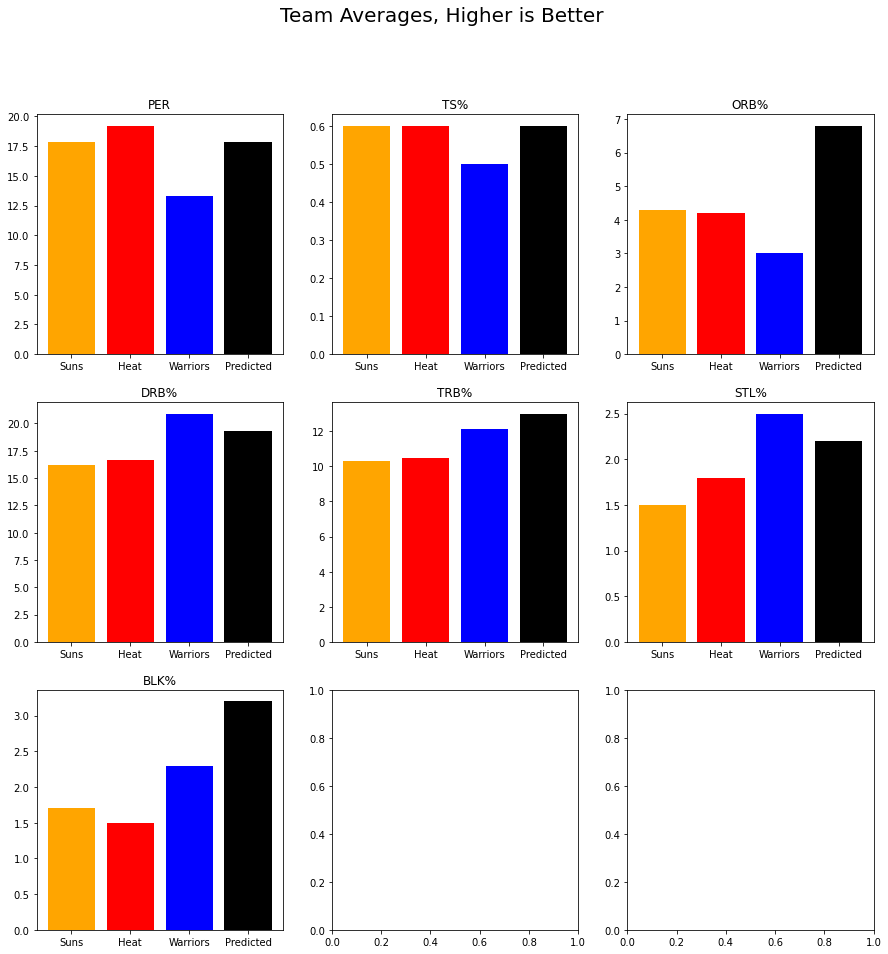

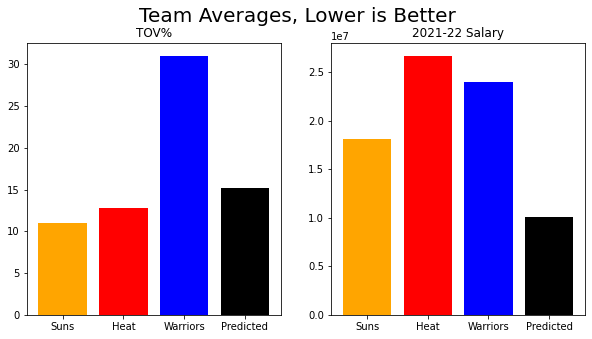

In [65]:
suns_starters = ["Devin Booker", "Chris Paul", "Mikal Bridges", "Deandre Ayton", "Jae Crowder"]
warrs_starters = ["Steph Curry", "Klay Thompson", "Draymond Green", "Otto Porter Jr.", "Andrew Wiggings"]
heat_starters = ["Jimmy Butler", "Bam Adebayo", "Duncan Robinson", "PJ Tucker", "Kyle Lowry"]



subset = parsed_data[parsed_data["Player"].isin(suns_starters)]
subset_avgs_suns = pd.DataFrame(subset.mean(axis=0).round(1))

subset = parsed_data[parsed_data["Player"].isin(heat_starters)]
subset_avgs_heat = pd.DataFrame(subset.mean(axis=0).round(1))

subset = parsed_data[parsed_data["Player"].isin(warrs_starters)]
subset_avgs_warrs = pd.DataFrame(subset.mean(axis=0).round(1))

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
row = 0
col = 0

fig.suptitle("Team Averages, Higher is Better", fontsize=20)
for column in parsed_data.iloc[:, 2:23]:
    if column in ["PER", "TS%", "ORB%", "DRB%", "TRB%", "BLK%", "STL%"]:
        x = ["Suns", 'Heat', 'Warriors', "Predicted"]
        y = [subset_avgs_suns.loc[column].values[0], subset_avgs_heat.loc[column].values[0], subset_avgs_warrs.loc[column].values[0], predicted_avgs[column].values[0]]
        axes[row, col].bar(x, y, color=['orange', 'red', 'blue', 'black'])
        axes[row, col].set_title(column)

        col += 1

        if col == 3:
            col = 0
            row += 1
        
print("\n")


fig, axes = plt.subplots(1, 2, figsize=(10, 5))
row = 0
col = 0

fig.suptitle("Team Averages, Lower is Better", fontsize=20)
for column in parsed_data.iloc[:, 2:23]:
    if column in ["TOV%"]:
        x = ["Suns", 'Heat', 'Warriors', "Predicted"]
        y = [subset_avgs_suns.loc[column].values[0], subset_avgs_heat.loc[column].values[0], subset_avgs_warrs.loc[column].values[0], predicted_avgs[column].values[0]]
        axes[0].bar(x, y, color=['orange', 'red', 'blue', 'black'])
        axes[0].set_title(column)
    if column in ["2021-22 Salary"]:
        x = ["Suns", 'Heat', 'Warriors', "Predicted"]
        y = [subset_avgs_suns.loc[column].values[0], subset_avgs_heat.loc[column].values[0], subset_avgs_warrs.loc[column].values[0], predicted_avgs[column].values[0]]
        axes[1].bar(x, y, color=['orange', 'red', 'blue', 'black'])
        axes[1].set_title(column)        
        
print("\n")


# Looking at Distribution of Players in Predicted Teams

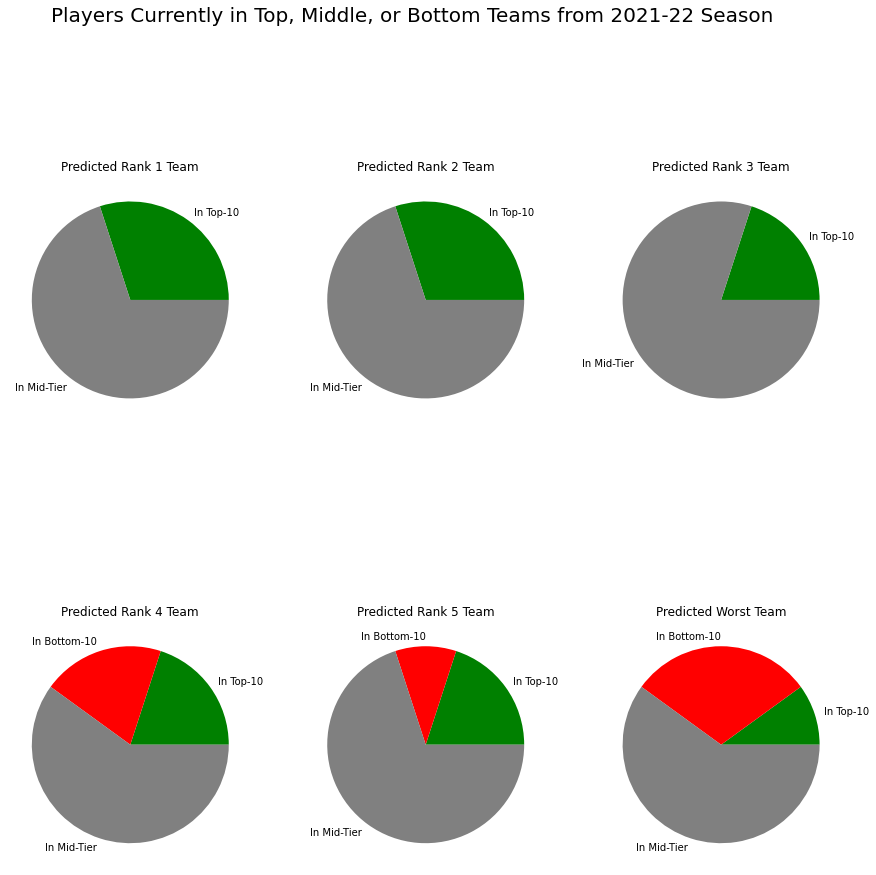

In [38]:
fig, axes = plt.subplots(2, 3, figsize=(15, 15))
row = 0
col = 0

fig.suptitle("Players Currently in Top, Middle, or Bottom Teams from 2021-22 Season", fontsize=20)

for i in range(len(info)):
    stats, averages, player_names, total_salary, num_wins = info[i]
    player_teams = set(map(lambda s : teams_dict[s], stats["Tm"]))
    top_overlap = len(player_teams.intersection(top_10_teams))
    bot_overlap = len(player_teams.intersection(bot_10_teams))
    
    if top_overlap == 0: 
        sizes = [bot_overlap * 10, 100 - (bot_overlap * 10)]
        axes[row, col].pie(sizes, labels=["In Bottom-10", "In Mid-Tier"], colors=["Red", "Grey"])
    elif bot_overlap == 0:
        sizes = [top_overlap * 10, 100 - (top_overlap * 10)]
        axes[row, col].pie(sizes, labels=["In Top-10", "In Mid-Tier"], colors=["Green", "Grey"]) 
    else:
        sizes = [top_overlap * 10, bot_overlap * 10, 100 - (bot_overlap * 10 + top_overlap * 10)]
        axes[row, col].pie(sizes, labels=["In Top-10", "In Bottom-10", "In Mid-Tier"], colors=["Green", "Red", "Grey"]) 

    axes[row, col].set_title("Predicted Rank " + str(i + 1) + " Team")
        
    col += 1
    
    if col == 3:
        col = 0
        row += 1   
        
        
stats, averages, player_names, total_salary, num_wins = get_pred_info(extra_pred_y, get_worst=True)
player_teams = set(map(lambda s : teams_dict[s], stats["Tm"]))
top_overlap = len(player_teams.intersection(top_10_teams))
bot_overlap = len(player_teams.intersection(bot_10_teams))
axes[1, 2].set_title("Predicted Worst Team")
if top_overlap == 0: 
    sizes = [bot_overlap * 10, 100 - (bot_overlap * 10)]
    axes[1, 2].pie(sizes, labels=["In Bottom-10", "In Mid-Tier"], colors=["Red", "Grey"])
elif bot_overlap == 0:
    sizes = [top_overlap * 10, 100 - (top_overlap * 10)]
    axes[1, 2].pie(sizes, labels=["In Top-10", "In Mid-Tier"], colors=["Green", "Grey"]) 
else:
    sizes = [top_overlap * 10, bot_overlap * 10, 100 - (bot_overlap * 10 + top_overlap * 10)]
    axes[1, 2].pie(sizes, labels=["In Top-10", "In Bottom-10", "In Mid-Tier"], colors=["Green", "Red", "Grey"])  